In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
RANDOM_SEED = 17
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {DEVICE}')

batch_size = 4
num_workers = 0

Current device cpu


Создание словаря кодирования

In [130]:
names = [name.split('.')[0] for name in os.listdir('samples') if '.' in name]

chars = list("".join(names))
chars = sorted(np.unique(chars))

id_to_ch = {i + 1: ch for i, ch in enumerate(chars)}
id_to_ch[0] = "_"
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

ch_to_id

{'2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 'b': 8,
 'c': 9,
 'd': 10,
 'e': 11,
 'f': 12,
 'g': 13,
 'm': 14,
 'n': 15,
 'p': 16,
 'w': 17,
 'x': 18,
 'y': 19,
 '_': 0}

Доступ к данным

In [131]:
class CaptchaDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, image_paths, transform=None, encode_table=None):
        self.dir_path = dir_path
        self.transform = transform
        self.encode_table = encode_table
        self.image_paths_id = []
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, index):
        path_to_image = self.image_paths[index]
        label = path_to_image.split('.')[0]
        if self.encode_table:
            label = torch.tensor([self.encode_table[ch] for ch in label], dtype=torch.long)

        with Image.open(self.dir_path + '/' + path_to_image).convert('RGB') as img:
            img.load()
        
        if self.transform:
            img = self.transform(img)

        return (img, label)
    



In [132]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = "samples"

image_paths = [name for name in os.listdir(data_dir) if '.' in name]

train_paths, test_paths = train_test_split(image_paths, shuffle=True, test_size=0.2, random_state=RANDOM_SEED)



trainset = CaptchaDataset(dir_path=data_dir, image_paths=train_paths, encode_table=ch_to_id, transform=transform)
testset = CaptchaDataset(dir_path=data_dir, image_paths=test_paths, encode_table=ch_to_id, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
                                    
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)


In [133]:
len(trainset), len(testset)

(856, 214)

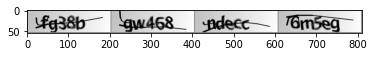

tensor([12, 13,  2,  7,  8])  tensor([13, 17,  3,  5,  7])  tensor([15, 10, 11,  9,  9])  tensor([ 5, 14,  4, 11, 13])


In [134]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:4]))
print('  '.join('{}'.format(labels[j]) for j in range(4)))

Обучение модели

In [135]:
import torch.nn as nn
import torch.nn.functional as F

class CaptchaModel(nn.Module):
    def __init__(self):
        super(CaptchaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2)
        )

        self.linear_1 = nn.Linear(832, 128)
        self.lstm = nn.LSTM(128, 32, bidirectional=True, batch_first=True)
        self.linear_2 = nn.Linear(64, 20)

    def forward(self, x, targets):
        bs, _, _, _ = x.size()
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear_1(x)
        x = nn.functional.relu(x)
        x, h = self.lstm(x)
        x = self.linear_2(x)
        x = x.permute(1, 0, 2)
        loss = None
        if targets is not None:
            log_probs = nn.functional.log_softmax(x, 2)
            
            input_lengths = torch.full(
                size=(bs,),
                fill_value=log_probs.size(0),
                dtype=torch.int32
            )

            target_lengths = torch.full(
                size=(bs,),
                fill_value=targets.size(1),
                dtype=torch.int32
            )

            loss = nn.CTCLoss(blank=0)(log_probs, targets, input_lengths, target_lengths)

        return x, loss

In [136]:
def train(model, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        model.train()
        sum_loss = 0
        for images, targets in train_loader:
            optimizer.zero_grad()
            targets = targets.to(DEVICE)
            images = images.to(DEVICE)              
            train_pred, loss = model(images, targets)
            loss.requres_grad = True
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            loss.detach()

        train_loss = sum_loss / len(train_loader)          
        train_losses.append(train_loss)         
                
        model.eval()
        sum_loss = 0
        with torch.no_grad():
            for images, targets in test_loader:
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                val_pred, loss = model(images, targets)
                loss.requres_grad = True
                sum_loss += loss.item()

        val_loss = sum_loss / len(test_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, train loss: {round(train_loss, 4)},  val. loss: {round(val_loss, 4)}")

    return train_losses, val_losses

In [137]:
model = CaptchaModel()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 90

train_loss, val_loss = train(model, optimizer, trainloader, testloader, num_epochs)

Epoch: 10, train loss: 3.2384,  val. loss: 3.2284
Epoch: 20, train loss: 0.766,  val. loss: 0.7033
Epoch: 30, train loss: 0.1741,  val. loss: 0.1786
Epoch: 40, train loss: 0.0505,  val. loss: 0.0769
Epoch: 50, train loss: 0.0266,  val. loss: 0.1363
Epoch: 60, train loss: 0.0098,  val. loss: 0.0417
Epoch: 70, train loss: 0.003,  val. loss: 0.0298
Epoch: 80, train loss: 0.0023,  val. loss: 0.0275
Epoch: 90, train loss: 0.0009,  val. loss: 0.0369


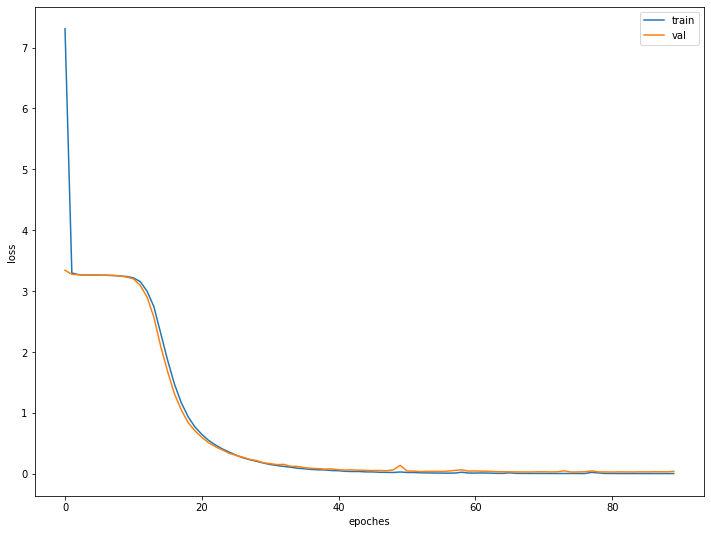

In [143]:
def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(12, 9))
    plt.plot(train_loss, label = 'train')
    plt.plot(val_loss, label = 'val')
    plt.xlabel('epoches')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
plot_losses(train_loss, val_loss)

Подсчет метрик

In [144]:
def decode(batch_pred, encoder):
    pred_labels = []
    for j in range(batch_pred.shape[1]):
        pred = batch_pred[:, j, :].unsqueeze(1)
        pred = torch.argmax(torch.softmax(pred.permute(1, 0, 2), 2), 2)
        pred = pred.detach().cpu().numpy().squeeze()

        pred_full = []
        for n in pred:
            if n == 0:
                pred_full.append('_')
            else:
                pred_full.append(encoder.inverse_transform([n])[0])

        pred_no_dubl = [pred_full[0]]
        for i in range(1, len(pred_full)):
            if pred_no_dubl[-1] != pred_full[i]:
                pred_no_dubl.append(pred_full[i])
                
        pred_no_blank = []
        for pred_chr in pred_no_dubl:
            if pred_chr != '_':
                pred_no_blank.append(pred_chr)
        pred_labels.append("".join(pred_no_blank))

    return pred_labels

In [145]:
from torchmetrics import CharErrorRate

def evaluate(model, test_loader, encoder):
    model.eval()
    cer_loss = CharErrorRate()
    predictions = []
    pred_labels = []    
    test_labels = []
    test_img = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            test_pred, loss = model(images, targets)
            predictions.append(test_pred.detach())

    for pred in predictions:
        pred_labels.extend(decode(pred, encoder))

    for images, labels in test_loader:
        for ind, label in enumerate(labels):
            label = label.type(torch.int).tolist()
            test_labels.append(''.join(encoder.inverse_transform(label)))
            test_img.append(images[ind].squeeze())
      
    test_cer_loss = cer_loss(pred_labels, test_labels).item()        
    test_result_summary = []
    for ind in range(len(test_labels)):
        img = test_img[ind]
        summary = dict()
        summary["data"] = img
        summary["char_err"] = cer_loss(pred_labels[ind], test_labels[ind]).item()
        summary["label"] = test_labels[ind]
        summary["prediction"] = pred_labels[ind]
        test_result_summary.append(summary)

    return test_cer_loss, test_result_summary

In [146]:
from sklearn.preprocessing import LabelEncoder
labels_arr = [list(i) for i in names]
labels_arr_flatten = [j for i in labels_arr for j in i ] + ['_']
label_encoder = LabelEncoder()
label_encoder.fit(labels_arr_flatten)

test_cer_loss, test_result_summary = evaluate(model, testloader, label_encoder)
print(f"CharErrorRate: {test_cer_loss}")

CharErrorRate: 0.0607476644217968


Анализ ошибок модели

        Label: xcf__
   Prediction: xcf
CharErrorRate: 0.4


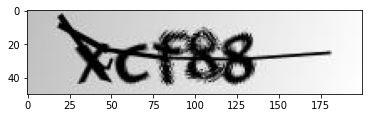

        Label: __bgx
   Prediction: bgx
CharErrorRate: 0.4


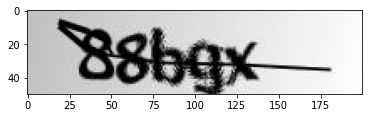

        Label: 3_45_
   Prediction: 345
CharErrorRate: 0.4


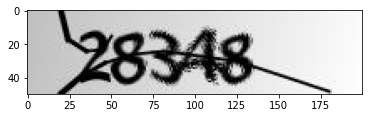

        Label: _gmnx
   Prediction: gmmx
CharErrorRate: 0.4


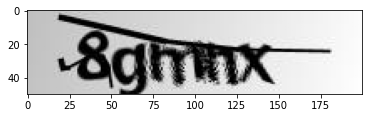

        Label: mmg4_
   Prediction: mng4
CharErrorRate: 0.4


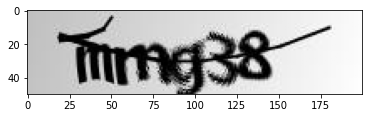

        Label: mye7_
   Prediction: mmye7
CharErrorRate: 0.4


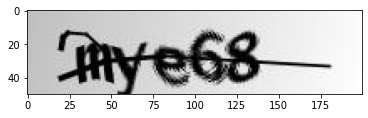

        Label: b3_g_
   Prediction: b3g
CharErrorRate: 0.4


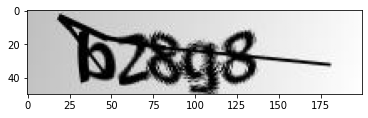

        Label: f_6_x
   Prediction: f6x
CharErrorRate: 0.4


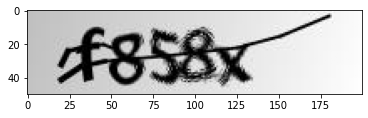

        Label: b7_6n
   Prediction: b76n
CharErrorRate: 0.2


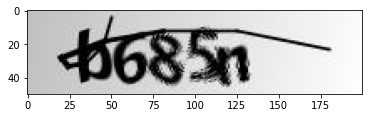

        Label: 6n83_
   Prediction: 6n83
CharErrorRate: 0.2


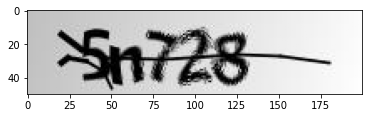

In [148]:
quantity = 10
test_result_summary = sorted(test_result_summary, key=lambda x: x["char_err"], reverse=True)
for img in test_result_summary[:quantity]:
    print(f"        Label: {img['label']}\n   Prediction: {img['prediction']}")
    print(f"CharErrorRate: {round(img['char_err'], 4)}")
    imshow(img["data"])

 - CharErrorRate - 6%
 - Модель плохо распознаёт цифру 8. При этом иногда выдаёт её там, где не нужно. Возможно, проблема в преобразованиях изображения
 - Также проблема с зашумленными символами. Например, над цифрой 6 проходит линия, из за чего она воспринимается как 6. Проблема в том, что эти линии часто не отличаются от частей цифр.
 - Я думаю, что нужно добавлять аугментацию, поиграть с нормализацией. Возможно, было плохим решением рассматривать изображения в трёх каналах. 